In [1]:
!pip install aisuite[openai] -q
!pip install tavily-python -q
!pip install yfinance -q
!pip install matplotlib -q
!pip install pandas -q
# Optional: quiet some Colab dependency warnings
# !pip install "httpx[http2]==0.28.1" -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.6/948.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 3.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.53.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.2 which is incompatible.


In [2]:
import os, json, base64, re
from html import escape
from datetime import datetime
from typing import Any

import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from IPython.display import display, HTML, Markdown

import aisuite
from tavily import TavilyClient
from dotenv import load_dotenv

def log_agent_title_html(title, icon="🧠"):
    display(HTML(f"""
    <div style="padding:1em;margin:1em 0;background-color:#f0f4f8;border-left:6px solid #1976D2;">
      <h2 style="margin:0;color:#0D47A1;">{icon} {escape(title)}</h2>
    </div>"""))

def log_tool_call_html(tool_name, arguments):
    display(HTML(f"""
    <div style="border-left:4px solid #1976D2;padding:.8em;margin:1em 0;
                background-color:#e3f2fd;color:#0D47A1;">
      <strong>Tool Call:</strong> {escape(tool_name)}
      <pre style="background:#e8f0fe;padding:6px;border-radius:4px;">
{escape(str(arguments))}
      </pre>
    </div>"""))

def log_tool_result_html(result):
    display(HTML(f"""
    <div style="border-left:4px solid #558B2F;padding:.8em;margin:1em 0;
                background-color:#f1f8e9;color:#33691E;">
      <strong>Tool Result:</strong>
      <pre style="white-space:pre-wrap;font-size:13px;color:#2E7D32;">
{escape(str(result))}
      </pre>
    </div>"""))

def log_final_summary_html(content):
    display(HTML(f"""
      <div style="border-left:4px solid #2E7D32;padding:1em;margin:1em 0;
                  background-color:#e8f5e9;color:#1B5E20;">
        <strong>Final Summary:</strong>
        <pre style="white-space:pre-wrap;font-size:13px;">
{escape(content.strip())}
        </pre>
      </div>"""))


In [3]:
def anonymize_text(text: str, real: str, alias: str) -> str:
    """Replace real company name/ticker with an alias in a conservative way."""
    if not text or not real or not alias:
        return text

    variants = {
        real,
        real.upper(),
        real.lower(),
        real.title()
    }

    for v in variants:
        text = text.replace(v, alias)

    return text


In [4]:
# If running in Colab, try to pull keys from userdata
try:
    from google.colab import userdata
    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
    os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
except Exception:
    pass

load_dotenv()

assert os.getenv("OPENAI_API_KEY"), "Missing OPENAI_API_KEY"
assert os.getenv("TAVILY_API_KEY"), "Missing TAVILY_API_KEY"

client = aisuite.Client()
tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

print("aisuite and Tavily clients ready")


aisuite and Tavily clients ready


In [5]:
def sec_filings_search_tool(query: str, max_results: int = 5, include_images: bool = False):
    """
    Tavily search for filings, transcripts, IR, documentation, ratings commentary, etc.
    Returns a list of {title, content, url}.
    """
    log_tool_call_html("sec_filings_search_tool", {"query": query, "max_results": max_results})

    clean_query = " ".join(query.split())
    try:
        response = tavily_client.search(
            query=clean_query,
            max_results=max_results,
            include_images=include_images,
        )
        results = [
            {"title": r.get("title"), "content": r.get("content"), "url": r.get("url")}
            for r in response.get("results", [])
        ]
        log_tool_result_html(results)
        return results
    except Exception as e:
        err = [{"title": "Error", "content": f"Tavily API call failed: {e}", "url": None}]
        log_tool_result_html(err)
        return err


def consensus_api_tool(ticker: str):
    """
    Tavily search for analyst expectations, consensus numbers, KPI trends.
    Returns a list of snippet dicts.
    """
    query = f"{ticker} earnings consensus analyst expectations"
    clean_query = " ".join(query.split())
    return sec_filings_search_tool(query=clean_query, max_results=5)


def price_history_tool(ticker: str, lookback_days: int = 90) -> pd.DataFrame:
    """
    Historical price data via Yahoo Finance for a quick risk/sentiment reference.
    """
    log_tool_call_html("price_history_tool", {"ticker": ticker, "lookback_days": lookback_days})
    df = yf.download(ticker, period=f"{lookback_days}d", interval="1d", progress=False)
    df.reset_index(inplace=True)
    log_tool_result_html(df.head().to_string())
    return df


In [6]:
def research_agent(ticker: str):
    """
    PE / Private Credit Underwriting and Business Overview Agent.

    Uses Tavily-based tools:
    - sec_filings_search_tool
    - consensus_api_tool

    Returns a Markdown Underwriting Brief.
    """
    log_agent_title_html("Underwriting and Business Overview Agent", "🧩")

    log_tool_result_html(f"Searching SEC filings, transcripts, and IR data for {ticker}...")
    sec_query = (
        f"{ticker} capital structure leverage refinancing risk covenants "
        f"latest 10-K 10-Q earnings call transcript investor presentation"
    )
    sec_results = sec_filings_search_tool(query=sec_query, max_results=4)

    log_tool_result_html(f"Fetching consensus and market expectations for {ticker}...")
    consensus_results = consensus_api_tool(ticker)
    log_tool_result_html("Consensus / expectations retrieved.")

    prompt = f"""
You are a private credit and private equity underwriter preparing an Underwriting Brief
for the company represented by ticker {ticker}.

You have two Tavily-based sources:
1. SEC filings, IR updates, and transcripts:
{sec_results}

2. Street / analyst expectations and commentary:
{consensus_results}

Your tasks:
1. Write a section titled "Business Overview and Positioning" describing what the company does,
   how it makes money, and its competitive / industry context as far as can be inferred.
2. Write a section titled "Recent Developments and Management Tone" summarizing strategic moves,
   capital allocation, balance sheet commentary, leverage or rating focus, and key messages from management.
3. Create a Markdown table titled "Guidance vs Market Expectations"
   with columns: Metric | Management Commentary | Market / Analyst Expectations | Underwriter Comment.
   Use qualitative placeholders when exact numbers are not available.
4. End with a short section titled "Underwriting Questions to Explore" listing 3–6 key questions
   you would want to answer before committing private credit or PE capital.

Tone: concise, factual, underwriter-focused. Do not fabricate precise numbers; keep it qualitative when needed.

Today’s date: {datetime.now().strftime("%Y-%m-%d")}
"""

    response = client.chat.completions.create(
        model="openai:o4-mini",
        messages=[{"role": "user", "content": prompt}],
    )

    summary = response.choices[0].message.content.strip()
    log_final_summary_html(summary)
    return summary


In [7]:
def analyst_agent(ticker: str, underwriting_brief: str):
    """
    Financial and Credit Metrics Agent.

    Deepens the Underwriting Brief into a credit-focused view:
    - historical performance (growth, margins, cash flow quality)
    - leverage, coverage, liquidity (qualitative)
    - base / downside / upside scenarios
    - overall credit view.
    """
    log_agent_title_html("Financial and Credit Metrics Agent", "📊")

    prompt = f"""
You are the Financial and Credit Metrics Agent in a private credit and private equity deal team.

The opportunity is represented by ticker {ticker}.
You are given the following Underwriting Brief:

{underwriting_brief}

Your tasks:
1. Draft a section titled "Historical Financial Performance and Cash Flow Profile"
   describing revenue growth trend, margin profile, cash conversion, and capital intensity,
   using qualitative language based on the brief and any hints from filings and consensus.
2. Draft a section titled "Leverage, Coverage, and Liquidity"
   where you discuss:
   - Reasonable leverage bands (e.g., low, moderate, high) for this business
   - Qualitative sense of interest coverage and refinancing risk
   - Any known or likely liquidity considerations.
3. Draft a section titled "Scenario Analysis (Base, Downside, Upside)"
   with three short sub sections: Base Case, Downside Case, Upside Case.
   For each, describe qualitatively how revenue, margins, and cash flow might evolve
   and what that implies for leverage and covenant headroom.
4. End with a short section titled "Credit View"
   stating whether you see the credit quality as strong, acceptable, or weak for private credit,
   and why.

Do not invent specific numbers not supported by the text.
Be explicit that all scenarios and leverage commentary are qualitative and indicative.
"""

    response = client.chat.completions.create(
        model="openai:o4-mini",
        messages=[{"role": "user", "content": prompt}],
    )

    summary = response.choices[0].message.content.strip()
    log_final_summary_html(summary)
    return summary


In [8]:
def qualitative_risk_agent(ticker: str, underwriting_brief: str):
    """
    Market and Qualitative Risk Agent, tuned for private credit.

    Focus:
    - sector / macro issues
    - revenue diversification and business lines
    - cost pass-through vs margin pressure
    - rising rates impact on borrower vs lender.
    """
    log_agent_title_html("Market and Qualitative Risk Agent", "🌐")

    prompt = f"""
You are the Market and Qualitative Risk Agent for a private credit investment committee.

The opportunity is represented by ticker {ticker}.
You are given the following Underwriting Brief:

{underwriting_brief}

Use this information, plus your general knowledge of how businesses in similar sectors behave, to do the following:

1. Write a section titled "Sector and Macro Issues"
   - Describe the key issues facing this sector and the broader economy.
   - Explicitly discuss how these issues might affect revenue stability and margins.
2. Write a section titled "Revenue Diversification and Business Lines"
   - Discuss how diversified the revenue appears to be:
     - number of business lines or segments
     - customer or end-market concentration where it can be inferred
     - cyclicality vs defensiveness.
3. Write a section titled "Cost Pass-Through and Margin Risk"
   - Analyze the company’s likely ability to pass cost inflation (materials, labor, etc.) on to customers.
   - Describe what happens if they can no longer pass through costs:
     - impact on margins
     - impact on cash flow available for debt service.
4. Write a section titled "Rising Rate Environment Impact"
   - Explain how rising interest rates affect:
     - the borrower’s interest expense and coverage
     - the lender’s income statement.
   - Be explicit that rising rates can be positive for the lender’s yield but negative for borrower stress.
5. Write a section titled "Key Qualitative Risks and Mitigants"
   - Provide 4–8 bullets, each stating:
     - the risk
     - why it matters to a direct lender
     - any mitigants you can see.
6. End with an "Overall Qualitative Risk Rating" of low, medium, or high,
   with 2–3 sentences explaining why from a lender’s point of view.

Be realistic about what can be inferred from the brief.
Do not fabricate specific events; reason from sector patterns where necessary and label those as inference.
"""

    response = client.chat.completions.create(
        model="openai:o4-mini",
        messages=[{"role": "user", "content": prompt}],
    )

    summary = response.choices[0].message.content.strip()
    log_final_summary_html(summary)
    return summary


In [9]:
def structure_covenants_agent(ticker: str):
    """
    Structure, Documentation and Covenants Agent.

    Focuses on:
    - capital structure (term loans, RCFs, bonds, other debt)
    - covenant package (max leverage, min liquidity, coverage tests)
    - security, guarantees, ranking
    - how the structure mitigates or fails to mitigate downside risk.
    """
    log_agent_title_html("Structure, Documentation and Covenants Agent", "📜")

    log_tool_result_html(f"Searching capital structure and covenant information for {ticker}...")
    cov_query = (
        f"{ticker} term loan credit agreement covenants leverage ratio minimum liquidity "
        f"maintenance covenant incurrence covenant security collateral ranking guarantor covenant-lite"
    )
    cov_results = sec_filings_search_tool(query=cov_query, max_results=6)

    prompt = f"""
You are the Structure, Documentation and Covenants specialist on a private credit deal team.

The opportunity is represented by the public ticker {ticker}.

Below are Tavily search results that may include:
- descriptions of the borrower's capital structure
- references to term loan, notes, revolvers, ABL, RCF, etc.
- summaries of covenants, security, and ranking
- rating agency commentary on documentation strength.

Raw search results:
{cov_results}

Your tasks:
1. Draft a section titled "Capital Structure Snapshot"
   - Describe, as far as the data allows, the key debt instruments (e.g., term loan B, RCF, notes).
   - Note ranking (senior secured, unsecured, subordinated) and any visible security or guarantees.
2. Draft a section titled "Covenant and Terms Overview"
   - Explain whether the deal appears to be covenant-lite or has meaningful maintenance covenants.
   - Highlight any references to:
     - maximum leverage covenants
     - minimum interest coverage or fixed charge coverage
     - minimum liquidity covenants
     - other key tests or springing covenants.
   - When details are not explicit, infer likely covenant style based on typical structures for the borrower profile and mention that you are inferring.
3. Draft a section titled "Downside Protection and Documentation Strength"
   - Assess how well the structure and documents protect the lender in a downside:
     - security package and guarantees
     - covenants that give early warning or remediation points
     - restrictions on leakage (dividends, asset sales, investments).
   - Be explicit about where downside protection appears strong, adequate, or weak.
4. End with a short bullet list called "Open Documentation Questions"
   - 3–6 bullets with questions an analyst should clarify by reviewing the actual credit agreement (e.g., baskets, carve-outs, EBITDA add-backs).

Keep the language focused on private credit risk and downside protection.
Do not pretend you have the full credit agreement; be clear where you are inferring market-standard terms.
"""

    response = client.chat.completions.create(
        model="openai:o4-mini",
        messages=[{"role": "user", "content": prompt}],
    )

    summary = response.choices[0].message.content.strip()
    log_final_summary_html(summary)
    return summary


In [10]:
def chart_maker_agent(ticker: str):
    """
    Creates a 90-day price trend visualization using price_history_tool.
    Used as a quick market-implied risk / sentiment reference in the memo.
    """
    log_agent_title_html("Chart Maker Agent", "📈")

    df = price_history_tool(ticker)
    if df.empty:
        log_tool_result_html("No price data available to chart.")
        return None

    plt.figure(figsize=(8, 4))
    plt.plot(df["Date"], df["Close"], linewidth=2)
    plt.title(f"{ticker} — 90-Day Price Trend")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.grid(True)
    chart_path = f"{ticker}_price_chart.png"
    plt.tight_layout()
    plt.savefig(chart_path)
    plt.close()

    log_tool_result_html(f"Chart saved: {chart_path}")
    return chart_path


In [11]:
def ic_coordinator_agent(
    ticker: str,
    underwriting_brief: str,
    financial_notes: str,
    qualitative_risk_notes: str,
    structure_notes: str,
) -> str:
    """
    IC Coordinator Agent specialized for private credit.

    Integrates:
    - underwriting / business overview
    - financial & credit metrics
    - sector / macro / qualitative risk
    - structure, documentation and covenants
    """
    log_agent_title_html("IC Coordinator Agent", "🧮")

    prompt = f"""
You are the IC Coordinator for a private credit and private equity investment committee.

The opportunity is represented by ticker {ticker}.

You have four internal notes:

Underwriting and Business Overview:
{underwriting_brief}

Financial and Credit Metrics:
{financial_notes}

Market and Qualitative Risk View:
{qualitative_risk_notes}

Structure, Documentation and Covenants:
{structure_notes}

Your tasks:
1. Reconcile these perspectives into a single Investment Committee style narrative, thinking like a downside-focused lender.
2. Explicitly comment on:
   - Business resilience and revenue diversification.
   - Cost pass-through and what happens if it fades.
   - Impact of a higher rate environment on the borrower’s ability to service debt.
   - Strength of the documentation and covenant package (including any weaknesses).
   - The main “buttons” the lender has to protect downside (security, covenants, pricing, terms, flex, etc.).
3. State clearly what level of leverage you would be comfortable underwriting:
   for example, "We are only comfortable with low leverage," or "moderate leverage is acceptable given X and Y."
4. Assign one of three decisions:
   - INVEST    → proceed with the deal
   - DECLINE   → do not proceed (deal is unattractive)
   - WATCHLIST → interesting but requires more work or better terms
5. Think about how you would defend this recommendation to LPs who care deeply about downside protection.
6. At the end, output a single line in this exact format:
   JSON_DECISION: {{"decision": "INVEST" or "DECLINE" or "WATCHLIST", "confidence": a number between 0.5 and 0.9}}

You must not use any other labels or keys in that JSON object.
Keep your narrative concise but specific; mention concrete risk-mitigating factors and open issues.
"""

    response = client.chat.completions.create(
        model="openai:o4-mini",
        messages=[{"role": "user", "content": prompt}],
    )

    text = response.choices[0].message.content.strip()
    log_final_summary_html(text)
    return text
def parse_json_decision_from_ic_output(text: str) -> dict:
    """
    Extract JSON_DECISION from IC Coordinator output.
    Default: WATCHLIST with 0.5 confidence if parsing fails.

    Expected JSON:
    {"decision": "INVEST" | "DECLINE" | "WATCHLIST", "confidence": 0.5–0.9}
    """
    pattern = r"JSON_DECISION:\s*(\{.*\})"
    m = re.search(pattern, text, flags=re.I | re.S)
    if not m:
        return {"decision": "WATCHLIST", "confidence": 0.5}

    try:
        j = json.loads(m.group(1))
    except Exception:
        return {"decision": "WATCHLIST", "confidence": 0.5}

    # Normalize the label
    decision = str(j.get("decision", "WATCHLIST")).upper()
    conf = float(j.get("confidence", 0.5))

    # Enforce private credit decision set
    valid = {"INVEST", "DECLINE", "WATCHLIST"}
    if decision not in valid:
        decision = "WATCHLIST"

    return {"decision": decision, "confidence": conf}



In [12]:
def investment_memo_packaging_agent(
    ticker: str,
    underwriting_brief: str,
    financial_notes: str,
    qualitative_risk_notes: str,
    structure_notes: str,
    ic_output: str,
    chart_path: str,
    output_path: str = None,
    real_name: str = None,
    alias_name: str = None,
) -> str:

    """
    Packages all agent outputs into a PE / Private Credit Investment Committee memo in Markdown.

    Sections:
    1. Executive Summary
    2. Sponsor, Transaction and Use of Proceeds
    3. Business Model, Revenue Diversification and Market Context
    4. Historical Financial Performance and Credit Metrics
    5. Structure, Documentation and Covenants
    6. Downside Protection and Loss Pathways
    7. Key Risks and Mitigants
    8. Recommendation and IC Q&A Prep
    """
    log_agent_title_html("Investment Memo Packaging Agent", "📦")

    if output_path is None:
        output_path = f"{ticker}_PE_PrivateCredit_Investment_Memo_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.md"

    # Chart embedding
    chart_md = ""
    if chart_path is not None:
        try:
            with open(chart_path, "rb") as f:
                b64_chart = base64.b64encode(f.read()).decode("utf-8")
            chart_md = (
                f'<p align="center"><img src="data:image/png;base64,{b64_chart}" width="600"/></p>\n'
                f'<p align="center"><em>Figure: {ticker} price trend (last 90 days)</em></p>'
            )
        except Exception as e:
            chart_md = f"_Chart unavailable: {e}_"

    decision_json = parse_json_decision_from_ic_output(ic_output)

    refinement_prompt = f"""
You are an experienced private credit Investment Committee memo writer.

You will receive:
- Underwriting and Business Overview notes
- Financial and Credit Metrics notes
- Market and Qualitative Risk notes
- Structure, Documentation and Covenants notes
- IC Coordinator narrative and JSON decision

Underwriting notes:
{underwriting_brief}

Financial and Credit Metrics notes:
{financial_notes}

Market and Qualitative Risk notes:
{qualitative_risk_notes}

Structure, Documentation and Covenants notes:
{structure_notes}

IC Coordinator narrative and JSON decision:
{ic_output}

Parsed JSON decision:
{json.dumps(decision_json)}

Write a single cohesive Investment Committee memo in Markdown with these sections:

1. Executive Summary
2. Sponsor, Transaction and Use of Proceeds
3. Business Model, Revenue Diversification and Market Context
4. Historical Financial Performance and Credit Metrics
5. Structure, Documentation and Covenants
6. Downside Protection and Loss Pathways
7. Key Risks and Mitigants
8. Recommendation and IC Q&A Prep

Guidance:
- Use only the following decision labels throughout the memo:
    • INVEST  → proceed with the underwriting
    • DECLINE → do not proceed with the transaction
    • WATCHLIST → keep under review; further diligence or improved terms required
- Emphasize downside protection: covenants, security, structure, and how they mitigate loss pathways.
- Explicitly mention the scenario where cost pass-through fades and rates are higher for the borrower.
- Keep leverage, pricing, and covenants mostly qualitative unless clearly implied.
- Do not invent precise legal details; frame them as "based on available information, it appears that..."
- The tone should be concise, professional, and focused on downside protection.
"""
    memo_body = client.chat.completions.create(
        model="openai:o4-mini",
        messages=[
            {"role": "system", "content": "You write clear, professional private credit Investment Committee memos."},
            {"role": "user", "content": refinement_prompt},
        ],
    ).choices[0].message.content.strip()

    # Anonymize if requested
    real_name = real_name or ticker
    title_name = alias_name or ticker

    if alias_name:
        memo_body = anonymize_text(memo_body, real_name, alias_name)

    markdown_content = f"""
# {title_name} — Private Credit Investment Memo
Generated on {datetime.now().strftime('%B %d, %Y')}

{memo_body}

## Market Reference: Recent Price Trend

{chart_md}

Prepared automatically by the private credit agent suite using SEC filings, Tavily search, and market data.
"""

    with open(output_path, "w", encoding="utf-8") as f:
        f.write(markdown_content)

    log_final_summary_html(f"Investment memo written to {output_path}")
    return output_path


In [13]:
def run_investment_memo_pipeline(ticker: str) -> str:
    """
    Full Private Credit investment memo pipeline for a single ticker.

    Steps:
    1. research_agent               → Underwriting and Business Overview
    2. analyst_agent                → Financial and Credit Metrics
    3. qualitative_risk_agent       → Sector, macro, pass-through, rates
    4. structure_covenants_agent    → Structure, documentation and covenants
    5. chart_maker_agent            → Price trend chart
    6. ic_coordinator_agent         → Integrated IC narrative + JSON decision
    7. investment_memo_packaging_agent → Final IC memo

    Returns path to the Markdown memo.
    """
    print(f"Running Private Credit investment memo pipeline for {ticker}...")

    underwriting_output = research_agent(ticker)
    financial_output = analyst_agent(ticker, underwriting_output)
    qualitative_output = qualitative_risk_agent(ticker, underwriting_output)
    structure_output = structure_covenants_agent(ticker)
    chart_path = chart_maker_agent(ticker)

    ic_text = ic_coordinator_agent(
        ticker,
        underwriting_brief=underwriting_output,
        financial_notes=financial_output,
        qualitative_risk_notes=qualitative_output,
        structure_notes=structure_output,
    )

    memo_path = investment_memo_packaging_agent(
        ticker,
        underwriting_brief=underwriting_output,
        financial_notes=financial_output,
        qualitative_risk_notes=qualitative_output,
        structure_notes=structure_output,
        ic_output=ic_text,
        chart_path=chart_path,
    )

    print(f"Investment memo ready at {memo_path}")
    return memo_path


Running Private Credit investment memo pipeline for LMNR...


/tmp/ipython-input-242988176.py:42: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=f"{lookback_days}d", interval="1d", progress=False)


Investment memo ready at LMNR_PE_PrivateCredit_Investment_Memo_2025-12-10_14-20-12.md
Memo path: LMNR_PE_PrivateCredit_Investment_Memo_2025-12-10_14-20-12.md



# LMNR — Private Credit Investment Memo
Generated on December 10, 2025

```markdown
# Investment Committee Memo

## 1. Executive Summary
Limoneira Company (NASDAQ: LMNR) is a vertically integrated agribusiness and real‐estate developer with three cash‐flow engines: citrus/specialty‐fruit production, packing/cold‐storage services, and land‐development gains. Management is prioritizing debt refinancing ahead of sizable 2025 maturities and evaluating selective land‐bank monetizations to deleverage.  
Credit profile is acceptable on a qualitative basis, supported by first‐lien collateral and incurrence‐style covenants. However, net debt/EBITDA remains above peer medians, refinancing risk is elevated in a rising‐rate environment, and the capital structure is largely covenant‐lite.  
**Decision**: WATCHLIST  
**Confidence**: Moderate (0.75)  

## 2. Sponsor, Transaction and Use of Proceeds
- **Sponsor/Borrower**: Limoneira Company, a public agribusiness and real‐estate developer.  
- **Transaction**: Senior secured revolver (L+225–275bps, 0.50% floor) sized at ~$400 mm (≈$100 mm drawn) and potential term‐debt refinancing to replace 2025 maturities.  
- **Use of Proceeds**:  
  1. Extend or refinance upcoming debt maturities.  
  2. Improve covenant headroom.  
  3. Fund core capex (orchard replanting, mechanization, cold‐chain upgrades).  
  4. General corporate purposes, including potential bridge financing pending land‐sale or JV proceeds.  

## 3. Business Model, Revenue Diversification and Market Context
- **Segments**  
  • Fruit Production: Lemons, avocados, olives on CA/AZ acreage. Margins exposed to weather and input costs.  
  • Packing & Cold Storage: Fixed‐cost leverage under multi‐year contracts with CPI escalators; steadier contribution margins.  
  • Real‐Estate Development: Lumpy, high‐margin gains subject to housing starts, mortgage‐rate sensitivity, and timing risk.  
- **Market Factors**  
  • Commodity‐price cycles, FX in export markets.  
  • Water‐regulation and drought risk in California/AZ.  
  • Rising labor, energy, packaging and freight costs.  
  • Rate‐sensitive slowdown in real‐estate closings.  
- **Diversification** partially offsets cyclical swings, but the real‐estate line remains unpredictable and overall exposure to weather/input inflation is material.

## 4. Historical Financial Performance and Credit Metrics
- **Revenue Growth**: Flat to low‐single‐digit annually; quarter‐to‐quarter swings from weather and land‐sale timing.  
- **Margin Profile**:  
  • Fruit: Stable but pressured by cost inflation and limited spot‐price pass‐through.  
  • Packing: Higher, steadier margins with CPI escalators in contracts.  
  • Development: Lumpy; proceeds critical for FCF.  
- **Cash Flow & Leverage**:  
  • Free cash flow modest/neutral post‐capex; requires asset monetizations for growth.  
  • Net Debt/EBITDA above 3.0x (peer median ~2.5x).  
  • Interest coverage moderate; could compress if cost pass‐through fades or rates stay elevated.  
- **Liquidity**:  
  • Revolver capacity (subject to borrowing‐base).  
  • Seasonal working‐capital swings.  
  • Uncertain timing of land‐sale/JV proceeds.  

## 5. Structure, Documentation and Covenants
- **Security**  
  • RCF: First‐priority liens on most corporate and subsidiary assets; customary collateral package.  
  • Unsecured Notes (2026/2028): Pari passu, negative‐pledge only.  
- **Covenant Package** (based on available information)  
  • RCF: Borrowing‐base test; no quarterly maintenance leverage or coverage tests disclosed.  
  • Incurrence tests:  
    – Max consolidated net leverage ~5.5x LTM EBITDA for new acquisitions/dividends.  
    – Max secured leverage ~4.75x for new secured debt.  
    – Min fixed‐charge coverage ~2.0–2.5x for incremental financings.  
  • Springing covenants: Potential triggers for higher leverage/coverage breaches; lender election unclear.  
  • Restricted‐payment baskets: Likely limited; asset‐sale proceeds > de-minimis must prepay secured debt.  
- **Gaps**  
  • No quarterly maintenance tests on RCF or unsecured notes.  
  • Unclear add-back policies for EBITDA and cure/waiver mechanics.  

## 6. Downside Protection and Loss Pathways
- **Security Mitigation**  
  • First‐lien collateral on orchards, packhouses, land parcels.  
  • Intercreditor ring-fence of project‐level debt.  
- **Covenant Triggers**  
  • Incurrence tests block new leverage if metrics slipped.  
  • Springing covenants may restrict draws and distributions if leverage exceeds thresholds.  
- **Pricing Cushion**  
  • Revolver pricing (L+225–275bps, floor) and unsecured yields (5.375–6.125%) compensate for cyclical and refinancing risk.  
- **Loss Pathways**  
  1. Cost pass-through fades → gross‐margin compression → EBITDA/interest coverage deteriorates → liquidity stress.  
  2. Rising interest rates → higher debt service on revolver → reduced FCF cushion.  
  3. Delayed land‐sale/JV proceeds → inability to execute planned deleveraging → covenant headroom erosion.  
  4. Weather or water‐supply shocks → volume declines in fruit and under-utilized packing capacity.  

## 7. Key Risks and Mitigants
- **Refinancing & Covenant Risk**  
  • Risk: 2025 maturities and limited headroom.  
  • Mitigant: Ongoing lender negotiations; planned asset dispositions; incurrence‐style covenants cap new debt.  
- **Input‐Cost & Pricing Risk**  
  • Risk: Labor, freight, energy inflation outpaces spot prices.  
  • Mitigant: Packing contracts with CPI escalators; varietal diversification; water‐efficiency investments.  
- **Weather & Water Regulation**  
  • Risk: Drought, freeze events depress yields.  
  • Mitigant: Diversified crop mix; drip irrigation programs.  
- **Real‐Estate Timing**  
  • Risk: Higher mortgage rates delay land closings.  
  • Mitigant: Selective portfolio review; JV structures to share execution risk.  

## 8. Recommendation and IC Q&A Prep
**Recommendation: WATCHLIST**  
Limoneira’s tangible collateral, diversified cash streams and incurrence-style covenants provide a foundation for private‐credit exposure. However, refinancing execution risk in a higher‐rate environment and a covenant‐lite structure without quarterly maintenance tests warrant further diligence and stronger downside controls.  

**IC Q&A Prep**  
1. Confirm existence (or absence) of RCF quarterly maintenance tests and springing-covenant mechanics.  
2. Clarify permitted EBITDA add-backs and debt‐incurrence thresholds.  
3. Obtain detailed maturity extension commitments and documentation timelines.  
4. Review restricted-payment baskets, cash-trap triggers and cure/waiver periods.  
5. Schedule sensitivity analysis on cash flow under a scenario where cost pass-through fades and interest rates remain elevated.  
```

## Market Reference: Recent Price Trend

<p align="center">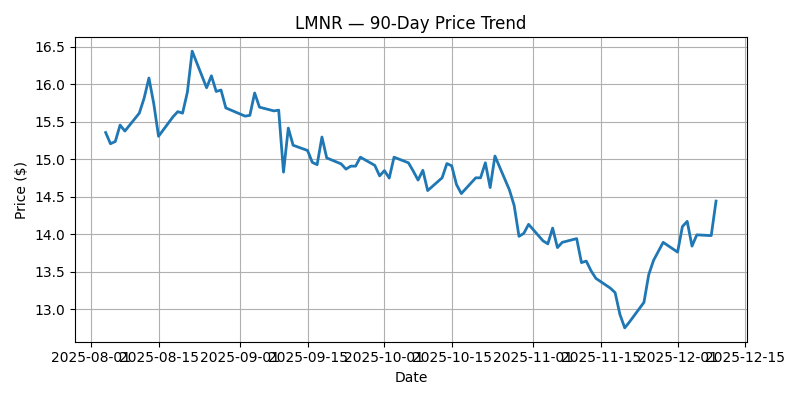</p>
<p align="center"><em>Figure: LMNR price trend (last 90 days)</em></p>

Prepared automatically by the private credit agent suite using SEC filings, Tavily search, and market data.


In [14]:
from IPython.display import Markdown

example_ticker = "LMNR"   # change this to any borrower proxy you want
alias_name = "LMNR Industries"  # fake name for demo

memo_path = run_investment_memo_pipeline(example_ticker)

print("Memo path:", memo_path)
with open(memo_path, "r", encoding="utf-8") as f:
    display(Markdown(f.read()))


In [15]:
!pip install python-docx -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Optional: ensure your memo folder exists immediately
os.makedirs("/content/drive/My Drive/PrivateCreditMemos", exist_ok=True)
print("Drive mounted + Memo folder ready")

In [ ]:
from docx import Document
from docx.shared import Inches
import os

def investment_memo_docx_agent(
    ticker: str,
    underwriting_brief: str,
    financial_notes: str,
    qualitative_risk_notes: str,
    structure_notes: str,
    ic_output: str,
    chart_path: str = None,
    drive_folder: str = "/content/drive/My Drive/PrivateCreditMemos",
    real_name: str = None,
    alias_name: str = None,
) -> str:
    """
    Generate a professional Private Credit IC memo as a Word (.docx) document
    and save it automatically to Google Drive.

    This version asks the model for PLAIN TEXT sections separated by markers,
    then parses them into the doc. No JSON goes into the Word output.
    """

    log_agent_title_html("Word IC Memo Packaging Agent", "📄")

    # Ensure destination folder exists in Drive
    os.makedirs(drive_folder, exist_ok=True)

    filename = f"{ticker}_PrivateCreditICMemo_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.docx"
    output_path = os.path.join(drive_folder, filename)

    decision_json = parse_json_decision_from_ic_output(ic_output)

    # ----- Ask LLM for SECTIONED TEXT (no JSON, no code fences) -----
    prompt = f"""
You are an experienced private credit Investment Committee memo writer.

You will receive:
- Underwriting and Business Overview notes
- Financial and Credit Metrics notes
- Market and Qualitative Risk notes
- Structure, Documentation and Covenants notes
- IC Coordinator narrative and JSON decision

Underwriting notes:
{underwriting_brief}

Financial and Credit Metrics notes:
{financial_notes}

Market and Qualitative Risk notes:
{qualitative_risk_notes}

Structure, Documentation and Covenants notes:
{structure_notes}

IC Coordinator narrative and JSON decision:
{ic_output}

Parsed JSON decision:
{decision_json}

Write the content for the following sections of a private credit IC memo
in PLAIN TEXT only. Do NOT use JSON. Do NOT use Markdown code fences. Do NOT add any extra commentary.

Put each section between the exact markers shown below:

<<EXEC_SUMMARY>>
[executive summary text here]
<<END_EXEC_SUMMARY>>

<<TRANS_OVERVIEW>>
[transaction overview text here]
<<END_TRANS_OVERVIEW>>

<<BUSINESS_OVERVIEW>>
[business model, revenue diversification, market context]
<<END_BUSINESS_OVERVIEW>>

<<FINANCIAL_OVERVIEW>>
[historical financial performance and credit metrics]
<<END_FINANCIAL_OVERVIEW>>

<<MARKET_SECTION>>
[sector and macro issues, pass-through, rate environment impact]
<<END_MARKET_SECTION>>

<<STRUCTURE_SECTION>>
[structure, documentation and covenants]
<<END_STRUCTURE_SECTION>>

<<DOWNSIDE_SECTION>>
[downside protection and loss pathways, including scenario where cost pass-through fades and rates rise]
<<END_DOWNSIDE_SECTION>>

<<KEY_RISKS_SECTION>>
[key risks and mitigants, can include bullet-like sentences]
<<END_KEY_RISKS_SECTION>>

<<RECOMMENDATION_SECTION>>
[final recommendation (INVEST / WATCHLIST / DECLINE) and IC Q&A prep]
<<END_RECOMMENDATION_SECTION>>

<<APPENDIX_SECTION>>
[appendix notes: price behavior, Tavily insights, other background]
<<END_APPENDIX_SECTION>>

Output ONLY these markers and the section texts. No JSON. No Markdown. No code fences.
"""

    response = client.chat.completions.create(
        model="openai:o4-mini",
        messages=[
            {"role": "system", "content": "You write structured private credit IC memo sections using the given markers."},
            {"role": "user", "content": prompt},
        ],
    )

    raw = response.choices[0].message.content.strip()

    # ----- Helper to extract text between markers -----
    def extract_block(text: str, start: str, end: str) -> str:
        pattern = re.compile(re.escape(start) + r"(.*?)" + re.escape(end), re.S)
        m = pattern.search(text)
        return m.group(1).strip() if m else ""

    sections = {
        "executive_summary": extract_block(raw, "<<EXEC_SUMMARY>>", "<<END_EXEC_SUMMARY>>"),
        "transaction_overview": extract_block(raw, "<<TRANS_OVERVIEW>>", "<<END_TRANS_OVERVIEW>>"),
        "business_overview": extract_block(raw, "<<BUSINESS_OVERVIEW>>", "<<END_BUSINESS_OVERVIEW>>"),
        "financial_overview": extract_block(raw, "<<FINANCIAL_OVERVIEW>>", "<<END_FINANCIAL_OVERVIEW>>"),
        "market_section": extract_block(raw, "<<MARKET_SECTION>>", "<<END_MARKET_SECTION>>"),
        "structure_section": extract_block(raw, "<<STRUCTURE_SECTION>>", "<<END_STRUCTURE_SECTION>>"),
        "downside_section": extract_block(raw, "<<DOWNSIDE_SECTION>>", "<<END_DOWNSIDE_SECTION>>"),
        "key_risks_section": extract_block(raw, "<<KEY_RISKS_SECTION>>", "<<END_KEY_RISKS_SECTION>>"),
        "recommendation_section": extract_block(raw, "<<RECOMMENDATION_SECTION>>", "<<END_RECOMMENDATION_SECTION>>"),
        "appendix_section": extract_block(raw, "<<APPENDIX_SECTION>>", "<<END_APPENDIX_SECTION>>"),
    }

    real_name = real_name or ticker
    title_name = alias_name or ticker

    if alias_name:
        for key, val in sections.items():
            sections[key] = anonymize_text(val, real_name, alias_name)

    # ----- Helper to write paragraphs and pseudo-bullets -----
    def add_section_text(doc: Document, text: str):
        if not text:
            return
        for line in text.splitlines():
            stripped = line.strip()
            if not stripped:
                continue
            # Treat lines that start with "-", "•" or "*" as bullets
            if stripped[0] in "-•*":
                p = doc.add_paragraph(stripped.lstrip("-•* ").strip())
                p.style = "List Bullet"
            else:
                doc.add_paragraph(stripped)

    # ----- Build the .docx -----
    doc = Document()

    # Cover page
    title = doc.add_heading(f"{title_name} – Private Credit Investment Committee Memorandum", level=0)
    title.alignment = 1  # center

    p = doc.add_paragraph()
    run = p.add_run(f"Generated on {datetime.now().strftime('%B %d, %Y')}")
    run.italic = True
    p.alignment = 1

    doc.add_paragraph(
        f"Decision: {decision_json.get('decision', 'WATCHLIST')} "
        f"(confidence {decision_json.get('confidence', 0.5):.2f})"
    )

    doc.add_page_break()

    # 1. Executive Summary
    doc.add_heading("1. Executive Summary", level=1)
    add_section_text(doc, sections["executive_summary"])

    # 2. Transaction Overview
    doc.add_heading("2. Transaction Overview", level=1)
    add_section_text(doc, sections["transaction_overview"])

    # 3. Business Model, Revenue Diversification and Market Context
    doc.add_heading("3. Business Model, Revenue Diversification and Market Context", level=1)
    add_section_text(doc, sections["business_overview"])
    add_section_text(doc, sections["market_section"])

    # 4. Historical Financial Performance and Credit Metrics
    doc.add_heading("4. Historical Financial Performance and Credit Metrics", level=1)
    add_section_text(doc, sections["financial_overview"])

    # 5. Structure, Documentation and Covenants
    doc.add_heading("5. Structure, Documentation and Covenants", level=1)
    add_section_text(doc, sections["structure_section"])

    # 6. Downside Protection and Loss Pathways
    doc.add_heading("6. Downside Protection and Loss Pathways", level=1)
    add_section_text(doc, sections["downside_section"])

    # 7. Key Risks and Mitigants
    doc.add_heading("7. Key Risks and Mitigants", level=1)
    add_section_text(doc, sections["key_risks_section"])

    # 8. Recommendation and IC Q&A Prep
    doc.add_heading("8. Recommendation and IC Q&A Prep", level=1)
    add_section_text(doc, sections["recommendation_section"])

    # Appendix
    doc.add_page_break()
    doc.add_heading("Appendix", level=1)
    add_section_text(doc, sections["appendix_section"])

    # Insert chart if available
    if chart_path is not None:
        try:
            doc.add_paragraph("Recent 90-Day Price Trend:")
            doc.add_picture(chart_path, width=Inches(6))
        except Exception as e:
            doc.add_paragraph(f"(Chart unavailable: {e})")

    # Save to Drive
    doc.save(output_path)
    log_final_summary_html(f"Word IC memo saved to Google Drive at:\n{output_path}")
    return output_path




In [ ]:
example_ticker = "LMNR"
alias_name = "LMNR Industries"  # fake name for demo

memo_path = run_investment_memo_pipeline(example_ticker)
print("Memo path:", memo_path)
with open(memo_path, "r", encoding="utf-8") as f:
    display(Markdown(f.read()))


In [ ]:
example_ticker = "LMNR"   # or another borrower proxy
alias_name = "LMNR Industries"  # fake name for demo


# Run the full pipeline to get the markdown memo
memo_path = run_investment_memo_pipeline(example_ticker)
print("Markdown memo path:", memo_path)
with open(memo_path, "r", encoding="utf-8") as f:
    display(Markdown(f.read()))

# Now rerun the core agents to feed the Word generator
underwriting_output = research_agent(example_ticker)
financial_output = analyst_agent(example_ticker, underwriting_output)
qualitative_output = qualitative_risk_agent(example_ticker, underwriting_output)
structure_output = structure_covenants_agent(example_ticker)
chart_path = chart_maker_agent(example_ticker)
ic_text = ic_coordinator_agent(
    example_ticker,
    underwriting_brief=underwriting_output,
    financial_notes=financial_output,
    qualitative_risk_notes=qualitative_output,
    structure_notes=structure_output,
)

docx_path = investment_memo_docx_agent(
    example_ticker,
    underwriting_brief=underwriting_output,
    financial_notes=financial_output,
    qualitative_risk_notes=qualitative_output,
    structure_notes=structure_output,
    ic_output=ic_text,
    chart_path=chart_path,
)

print("Word IC memo path:", docx_path)


In [ ]:
import os, base64, json
from datetime import datetime

def investment_memo_packaging_agent(
    ticker: str,
    underwriting_brief: str,
    financial_notes: str,
    qualitative_risk_notes: str,
    structure_notes: str,
    ic_output: str,
    chart_path: str,
    drive_folder: str = "/content/drive/My Drive/PrivateCreditMemos",
    real_name: str = None,
    alias_name: str = None,
) -> str:
    """
    Packages all agent outputs into a PE / Private Credit Investment Committee memo in Markdown
    and saves the .md file to Google Drive (drive_folder).

    Sections:
    1. Executive Summary
    2. Sponsor, Transaction and Use of Proceeds
    3. Business Model, Revenue Diversification and Market Context
    4. Historical Financial Performance and Credit Metrics
    5. Structure, Documentation and Covenants
    6. Downside Protection and Loss Pathways
    7. Key Risks and Mitigants
    8. Recommendation and IC Q&A Prep
    """

    log_agent_title_html("Investment Memo Packaging Agent", "📦")

    # Ensure destination folder exists in Google Drive
    os.makedirs(drive_folder, exist_ok=True)

    filename = f"{ticker}_PE_PrivateCredit_Investment_Memo_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.md"
    output_path = os.path.join(drive_folder, filename)

    # Chart embedding (inline base64)
    chart_md = ""
    if chart_path is not None:
        try:
            with open(chart_path, "rb") as f:
                b64_chart = base64.b64encode(f.read()).decode("utf-8")
            chart_md = (
                f'<p align="center"><img src="data:image/png;base64,{b64_chart}" width="600"/></p>\n'
                f'<p align="center"><em>Figure: {ticker} price trend (last 90 days)</em></p>'
            )
        except Exception as e:
            chart_md = f"_Chart unavailable: {e}_"

    decision_json = parse_json_decision_from_ic_output(ic_output)
    decision_label = decision_json.get("decision", "WATCHLIST")
    decision_conf = decision_json.get("confidence", 0.5)

    refinement_prompt = f"""
You are an experienced private credit Investment Committee memo writer.

You will receive:
- Underwriting and Business Overview notes
- Financial and Credit Metrics notes
- Market and Qualitative Risk notes
- Structure, Documentation and Covenants notes
- IC Coordinator narrative and JSON decision

Underwriting notes:
{underwriting_brief}

Financial and Credit Metrics notes:
{financial_notes}

Market and Qualitative Risk notes:
{qualitative_risk_notes}

Structure, Documentation and Covenants notes:
{structure_notes}

IC Coordinator narrative and JSON decision:
{ic_output}

Parsed JSON decision:
{json.dumps(decision_json)}

Write a single cohesive Investment Committee memo in Markdown with these sections:

1. Executive Summary
2. Sponsor, Transaction and Use of Proceeds
3. Business Model, Revenue Diversification and Market Context
4. Historical Financial Performance and Credit Metrics
5. Structure, Documentation and Covenants
6. Downside Protection and Loss Pathways
7. Key Risks and Mitigants
8. Recommendation and IC Q&A Prep

Guidance:
- Use only the following decision labels throughout the memo:
    • INVEST  → proceed with the underwriting
    • DECLINE → do not proceed with the transaction
    • WATCHLIST → keep under review; further diligence or improved terms required
- Emphasize downside protection: covenants, security, structure, and how they mitigate loss pathways.
- Explicitly mention the scenario where cost pass-through fades and rates are higher for the borrower.
- Keep leverage, pricing, and covenants mostly qualitative unless clearly implied.
- Do not invent precise legal details; frame them as "based on available information, it appears that..."
- The tone should be concise, professional, and focused on downside protection.
"""

    memo_body = client.chat.completions.create(
        model="openai:o4-mini",
        messages=[
            {"role": "system", "content": "You write clear, professional private credit Investment Committee memos."},
            {"role": "user", "content": refinement_prompt},
        ],
    ).choices[0].message.content.strip()

    # Anonymize if requested
    real_name = real_name or ticker
    title_name = alias_name or ticker

    if alias_name:
        memo_body = anonymize_text(memo_body, real_name, alias_name)

    markdown_content = f"""
# {title_name} — Private Credit Investment Memo
Generated on {datetime.now().strftime('%B %d, %Y')}

**Shadow Decision (internal): {decision_label}**
Confidence: {decision_conf:.2f}

{memo_body}

## Market Reference: Recent Price Trend

{chart_md}

Prepared automatically by the private credit agent suite using SEC filings, Tavily search, and market data.
"""

    # Save Markdown to Google Drive
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(markdown_content)

    log_final_summary_html(f"Investment memo written to {output_path}")
    return output_path


In [ ]:
investment_memo_packaging_agent(
    example_ticker,
    underwriting_brief=underwriting_output,
    financial_notes=financial_output,
    qualitative_risk_notes=qualitative_output,
    structure_notes=structure_output,
    ic_output=ic_text,
    chart_path=chart_path,
)